In [2]:
import random
import numpy as np
import torch
import torch.nn as nn
import pickle as pkl

In [3]:
import numpy as np

In [4]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [61]:
with open("/home/bxai1/BXAI/Project/NeuroTalk-decoder/CSP/sub001/data.pkl", 'rb') as f:
    data = pkl.load(f)
EEG = data[0].transpose(2,0,1)
EEG = torch.tensor(EEG ,dtype=torch.float)
label = data[1]
label = torch.tensor(label ,dtype=torch.long)

In [201]:
x= EEG.to(device)

In [190]:
import torch
from mamba_ssm.modules.mamba_simple import Mamba

batch, length, dim = 2, 128, 120
#x = torch.randn(batch, length, dim).to(device)
x= EEG.to(device)
model = Mamba(
    # This module uses roughly 3 * expand * d_model^2 parameters
    d_model=dim, # Model dimension d_model
    d_state=32,  # SSM state expansion factor
    d_conv=4,    # Local convolution width
    expand=2,    # Block expansion factor
).to(device)
y = model(x)
assert y.shape == x.shape
target = torch.randn(batch, length, dim).to(device)
x = x.requires_grad_(True)
print(y)

tensor([[[ 4.7134e+12, -3.1646e+12,  2.2230e+12,  ...,  1.3603e+12,
           3.1316e+10, -7.5743e+11],
         [ 1.7245e+13, -1.3646e+13,  5.1422e+12,  ...,  5.3839e+12,
           6.2694e+12, -1.5998e+13],
         [ 2.6647e+13, -2.9395e+13,  2.0948e+12,  ..., -1.5808e+12,
           7.3373e+12,  1.5656e+13],
         ...,
         [ 6.4112e+13, -5.2798e+13,  1.1262e+13,  ..., -1.7117e+13,
           1.2119e+13,  2.8864e+13],
         [ 6.4280e+13, -5.2976e+13,  1.1401e+13,  ..., -1.7225e+13,
           1.2146e+13,  2.9051e+13],
         [ 6.4166e+13, -5.2845e+13,  1.1299e+13,  ..., -1.7237e+13,
           1.2207e+13,  2.8916e+13]],

        [[ 4.8630e+12, -3.2731e+12,  2.2821e+12,  ...,  1.4064e+12,
           3.5668e+10, -7.7566e+11],
         [ 1.7713e+13, -1.4033e+13,  5.2040e+12,  ...,  5.5496e+12,
           6.4698e+12, -1.6409e+13],
         [ 2.7407e+13, -3.0270e+13,  2.1507e+12,  ..., -1.6385e+12,
           7.5296e+12,  1.6140e+13],
         ...,
         [ 6.5758e+13, -5

In [63]:
seed = 1

torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


In [131]:
class BlackMambaAutoEncoder(nn.Module):
    def __init__(self, input_dim, latent_dim, d_model, d_state, d_conv, expand, n_layers):
        super(BlackMambaAutoEncoder, self).__init__()

        self.encoder_mamba_layers = nn.ModuleList([
            nn.Sequential(
                Mamba(d_model=d_model, d_state=d_state, d_conv=d_conv, expand=expand),
                nn.LayerNorm(d_model)
            )
            for _ in range(n_layers)
        ])
        
        self.decoder_mamba_layers = nn.ModuleList([
            nn.Sequential(
                nn.LayerNorm(d_model),
                Mamba(d_model=d_model, d_state=d_state, d_conv=d_conv, expand=expand)
            )
            for _ in range(n_layers)
        ])

        self.encoder_proj = nn.Sequential(
            nn.Linear(input_dim, latent_dim * 2),
            nn.SiLU(),
            nn.Dropout(0.2),
            nn.Linear(latent_dim * 2, latent_dim)
        )
        
        self.decoder_proj = nn.Sequential(
            nn.Linear(latent_dim, latent_dim * 2),
            nn.SiLU(),
            nn.Dropout(0.2),
            nn.Linear(latent_dim * 2, input_dim)
        )

    def forward(self, x):
        for layer in self.encoder_mamba_layers:
            x = layer(x)
        latent = self.encoder_proj(x)
        x = self.decoder_proj(latent)
        for layer in self.decoder_mamba_layers:
            x = layer(x)
        return latent, x


In [132]:
# Define RMSE loss
class RMSELoss(nn.Module):
    def __init__(self):
        super(RMSELoss, self).__init__()
        self.mse = nn.MSELoss()

    def forward(self, pred, target):
        return torch.sqrt(self.mse(pred, target))

In [206]:
import torch
from torch.utils.data import TensorDataset, DataLoader

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Ensure data is stored on the CPU for DataLoader
Train_data = EEG[:6*13*4].to("cpu")  # Keep on CPU
Train_label = label[:, :6*13*4].to("cpu")  # Keep on CPU
Test_data = EEG[6*13*4:].to("cpu")  # Keep on CPU
Test_label = label[:, 6*13*4:].to("cpu")  # Keep on CPU

# Create TensorDatasets
TrainDataset = TensorDataset(Train_data, Train_label.permute(1, 0))
TestDataset = TensorDataset(Test_data, Test_label.permute(1, 0))

# Create DataLoaders
TrainDataloader = DataLoader(TrainDataset, batch_size=64, shuffle=True, num_workers=4, pin_memory=True)
TestDataloader = DataLoader(TestDataset, batch_size=64, shuffle=False, num_workers=4, pin_memory=True)


Using device: cuda


In [207]:
Train_data.shape

torch.Size([312, 491, 120])

In [220]:
import torch.optim as optim
import torch.nn as nn
from tqdm.notebook import tqdm
from mamba_ssm.modules.mamba_simple import Mamba
from torch.optim.lr_scheduler import StepLR

# Hyperparameters
lr = 1e-3
num_epochs = 100
input_dim = 120
latent_dim = 100
criterion = nn.SmoothL1Loss(beta=1.0)

# Model, optimizer, and device setup
model = BlackMambaAutoEncoder(
    input_dim=input_dim,
    latent_dim=latent_dim,
    d_model=input_dim,  # Model dimension
    d_state=128,   # SSM state expansion factor
    d_conv=4,     # Local convolution width
    expand=2,     # Block expansion factor
    n_layers=1
).to(device)

# Define optimizer with L2 regularization (weight decay)
optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-8)  # weight_decay is equivalent to L2 regularization

# Define a learning rate scheduler
scheduler = StepLR(optimizer, step_size=30, gamma=0.1)  # Reduce LR by a factor of 0.1 every 10 epochs

# Training loop
for epoch in tqdm(range(num_epochs)):
    model.train()
    total_loss = 0.0
    loss_list = []
    for index, (x, y) in enumerate(TrainDataloader):  # Ensure (x, y) unpacking
        x, y = x.to(device), y.to(device)  # Transfer data to GPU
        # Forward pass
        latent, reconstructed = model(x)  # Model returns both classification and reconstruction
        # Compute loss (using reconstruction loss with RMSE)
        loss = criterion(reconstructed, x)  # Compare reconstructed x with input x
        total_loss += loss.item()

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # Step the scheduler
    scheduler.step()  # Update learning rate
    # Epoch loss
    print(f"Epoch [{epoch+1}/{num_epochs}] Average Loss: {total_loss / len(TrainDataloader):.4f}")

# Evaluation loop
model.eval()
with torch.no_grad():
    total_loss = 0.0
    for x, y in TestDataloader:  # Ensure (x, y) unpacking
        x, y = x.to(device), y.to(device)  # Transfer data to GPU
        
        # Forward pass
        pred, reconstructed = model(x)
        
        # Compute loss (using RMSE for reconstruction)
        loss = criterion(reconstructed, x)  # Compare reconstructed x with input x
        total_loss += loss.item()
    
    # Print evaluation loss
    print(f"Test RMSE Loss: {total_loss / len(TestDataloader):.4f}")


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [1/100] Average Loss: 463.1138
Epoch [2/100] Average Loss: 462.7468
Epoch [3/100] Average Loss: 463.0527
Epoch [4/100] Average Loss: 462.7390
Epoch [5/100] Average Loss: 460.5339
Epoch [6/100] Average Loss: 455.7110
Epoch [7/100] Average Loss: 439.6572
Epoch [8/100] Average Loss: 380.0716
Epoch [9/100] Average Loss: 290.7007
Epoch [10/100] Average Loss: 245.9967
Epoch [11/100] Average Loss: 195.0693
Epoch [12/100] Average Loss: 168.7339
Epoch [13/100] Average Loss: 151.6511
Epoch [14/100] Average Loss: 138.4485
Epoch [15/100] Average Loss: 134.8270
Epoch [16/100] Average Loss: 126.0678
Epoch [17/100] Average Loss: 123.3890
Epoch [18/100] Average Loss: 118.3191
Epoch [19/100] Average Loss: 113.9346
Epoch [20/100] Average Loss: 112.0763
Epoch [21/100] Average Loss: 108.3294
Epoch [22/100] Average Loss: 100.6547
Epoch [23/100] Average Loss: 144.8996
Epoch [24/100] Average Loss: 130.9589
Epoch [25/100] Average Loss: 119.1923
Epoch [26/100] Average Loss: 110.0651
Epoch [27/100] Averag

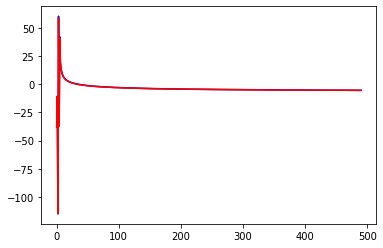

In [221]:
import matplotlib.pyplot as plt
#plt.plot(x[3,:,0].detach().cpu(), label = "Original", color = 'b')
plt.plot(model(x)[1][1,:,0].detach().cpu(), label = "Reconstuct", color = 'orange')
plt.plot(model(x)[1][2,:,0].detach().cpu(), label = "Reconstuct", color = 'blue')
plt.plot(model(x)[1][3,:,0].detach().cpu(), label = "Reconstuct", color = 'red')

In [200]:
model(x)[1].shape

torch.Size([28, 491, 120])